In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import datasets
import torch


data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
len(cifar10)

50000

In [32]:
img, label = cifar10[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x1DE2B15D400>, 1)

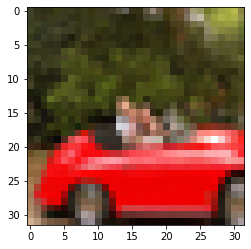

In [33]:
plt.imshow(img)
plt.show()

In [34]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [35]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [36]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [37]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [38]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [39]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

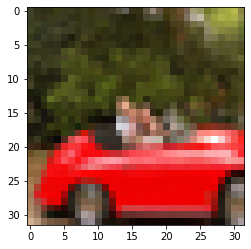

In [40]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()


### Normalize data

In [41]:
# Normalizing data
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape



torch.Size([3, 32, 32, 50000])

In [42]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [43]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [44]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [45]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


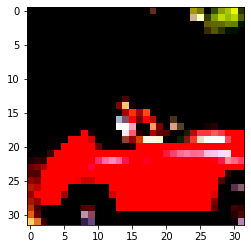

In [46]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### Building Dataset for Birds and Planes Classification

In [47]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in [0, 2]]

In [48]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, n_out),
                      nn.Softmax(dim=1))
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


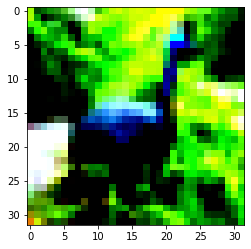

In [49]:
img, _ = cifar2[0]
 
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [50]:
img_batch = img.view(-1).unsqueeze(0)

In [51]:
out = model(img_batch)
out

tensor([[0.5695, 0.4305]], grad_fn=<SoftmaxBackward0>)

In [52]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, n_out),
                      nn.LogSoftmax(dim=1))
 

In [53]:
loss = nn.NLLLoss()
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
 
loss(out, torch.tensor([label]))


tensor(0.7362, grad_fn=<NllLossBackward0>)

In [54]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
                                         
def training_loop(model, loss_fn):

    learning_rate = 1e-2
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    n_epochs = 100
    
    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch <= 3 or epoch >= 96:
            print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


def val_loop(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    
    print("Accuracy: %f" % (correct / total))

In [55]:
model_1 = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

loss_fn_1 = nn.NLLLoss()

training_loop(model_1, loss_fn_1)
val_loop(model_1)

Epoch: 0, Loss: 0.465405
Epoch: 1, Loss: 0.533249
Epoch: 2, Loss: 0.258282
Epoch: 3, Loss: 0.404741
Epoch: 96, Loss: 0.012810
Epoch: 97, Loss: 0.032363
Epoch: 98, Loss: 0.064054
Epoch: 99, Loss: 0.020194
Accuracy: 0.814000


In [56]:
model_2 = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))
 
loss_fn_2 = nn.CrossEntropyLoss()
training_loop(model_2, loss_fn_2)
val_loop(model_2)

Epoch: 0, Loss: 0.354152
Epoch: 1, Loss: 0.527528
Epoch: 2, Loss: 0.395288
Epoch: 3, Loss: 0.599134
Epoch: 96, Loss: 0.000299
Epoch: 97, Loss: 0.000825
Epoch: 98, Loss: 0.000119
Epoch: 99, Loss: 0.000796
Accuracy: 0.810500
